# 4. Boreal Forest Height: Landscape summaries of North American boreal forest tree canopy cover trends (1984-2020)

Paul Montesano, PhD  
paul.m.montesano@nasa.gov

On MAAP:  
Run `build_stack_list` locally for a list of dicts indicating the gridded data you want to summarize

### Assessing recent site history: multi-decadal tree cover change
We assessed recent site history for 30 m pixels across the study domain built from a multi-decadal time series of maps derived from Landsat-based (Landsat Thematic Mapper, Enhanced Thematic Mapper, and Operational Land Imager) boreal tree canopy cover estimates 11,12. The time-series of boreal-calibrated tree canopy cover (TCC) maps exist for each year from 1984-2020 for the boreal forest biome 13, and are available through search.earthdata.nasa.gov. These TCC maps estimate the proportion of tree canopy > 5 m in height for each 30 m observation. The yearly time step of these maps across 36 years provides a robust basis for estimating the trend in these TCC estimates. From this time series, the recent forest structure change was calculated per-pixel using ordinary least squares regression. These calculations returned a slope and corresponding p-value estimate per-pixel for all available 30 m gridded estimates of TCC. This map was compiled for the boreal forest extent, a subset of this study domain.

In [3]:
from maap.maap import MAAP
maap = MAAP(maap_host='api.maap-project.org')

In [ ]:
#!pip install contextily

In [7]:
import rasterstats
import os
import geopandas as gpd
import pandas as pd
import glob
import datetime
!pip install xmltodict
import xmltodict
import sys
sys.path.append('/projects/code/icesat2_boreal/lib')
import ExtractUtils
import build_stack
import random

from multiprocessing import Pool
from functools import partial

import contextily as ctx

#### To run `build_stack.py` across a tiled raster dataset you need arguments that we'll gather into a dictionary

need to have a vector footprint of that dataset

#### Dictionary preparation makes this script very flexible and transferable to another s3 dataset

To run '`build_stack.py` across another dataset, just prepare another dictionary here and everything below should be exactly the same.  

In [11]:
INDEX_FN = 'https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/databank/boreal_height_cmip6/hydrobasins_L08_patterns_tte_boreal_tundra_3995.gpkg'
INDEX_LYR = 'hydrobasins_L08_patterns_tte_boreal_tundra_3995'

In [8]:
TILE_NUM = 7080224740

In [9]:
OUTDIR = '/projects/my-public-bucket/databank/boreal_height_cmip6/output/build_stack_basin_clips'
ZONAL_DIR = '/projects/my-public-bucket/databank/boreal_height_cmip6/output/zonal_stats'

VECTOR_DICT = {
                'INDEX_FN': INDEX_FN,
                'ID_COL_NAME': 'HYBAS_ID',
                'TILE_NUM':TILE_NUM,
                'INDEX_LYR': INDEX_LYR,
}

BUILD_STACK_DICT_LIST = [
                # tcc slope
                {
                            # data is accessed via its footprint, with a 's3_path' col identifying the s3 locations of each tile
                            'RASTER_NAME': 'terrapulse_tcc_slope',
                            'COVAR_TILE_FN': 'https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/databank/footprints/footprints_terrapulse-pub-data_tcc_slope-s3.gpkg',
                            'IN_COVAR_S3_COL': 's3_path',
                            'OUTDIR': OUTDIR,
                            'NODATA_VAL': 255,
                            'OUTPUT_CLIP_COG_FN':'',
                            'CREDENTIALS_FN': None
                        },
                # tcc pvalue
                {
                            # data is accessed via its footprint, with a 's3_path' col identifying the s3 locations of each tile
                            'RASTER_NAME': 'terrapulse_tcc_pvalue',
                            'COVAR_TILE_FN': 'https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/databank/footprints/footprints_terrapulse-pub-data_tcc_pvalue-s3.gpkg',
                            'IN_COVAR_S3_COL': 's3_path',
                            'OUTDIR': OUTDIR,
                            'NODATA_VAL': 255,
                            'OUTPUT_CLIP_COG_FN':'',
                            'CREDENTIALS_FN': None
                        }
]

In [10]:
HYBAS_ID_LIST = gpd.read_file(INDEX_FN).HYBAS_ID.to_list()
len(HYBAS_ID_LIST)

17052

In [12]:
import importlib
importlib.reload(build_stack)

def run_build_stack(HYBAS_ID):
    VECTOR_DICT['TILE_NUM'] = HYBAS_ID
    try:
        build_stack.build_stack_list(
                                covar_dict_list=BUILD_STACK_DICT_LIST, 
                                vector_dict=VECTOR_DICT, 
                                 tile_buffer_m=0, 
                                 res=30, clip=True,
                                 output_dir='/projects/my-public-bucket/databank/boreal_height_cmip6/output/build_stack_basin_clips',
                                 height=None, width=None,
                                 MAKE_DF=False
                                )
    except Exception as e: 
        print(e)
        print('Moving on...')
    
def rename_columns(GDF, bandname, stats_list):
    if stats_list is not None:
       
        names_list = ['val_'+ bandname + '_' + s for s in stats_list]
        rename_dict = dict(zip(stats_list, names_list))      
        GDF = GDF.rename(columns = rename_dict)
        
    return GDF

def extract_zonal_gdf_poly(HYBAS_ID, bandnames: list, GDF_fn, 
                           DATA_DIR = '/projects/my-public-bucket/databank/boreal_height_cmip6/output/build_stack_basin_clips',
                           OUTDIR = '/projects/my-public-bucket/databank/boreal_height_cmip6/output/zonal_stats',
                           ndval_list=[255,-9999], 
                           stats_list = ['max','min','median','mean','percentile_02','percentile_25','percentile_75','percentile_98','count']):
    
    r_fn = glob.glob(f'{DATA_DIR}/*{HYBAS_ID}*.tif')[0]
    GDF = gpd.read_file(GDF_fn)
    GDF = GDF[GDF.HYBAS_ID == HYBAS_ID]
    
    from rasterstats import zonal_stats
    import numpy as np
    import rasterio
    
    gdf_list = []
    
    try:
        with rasterio.open(r_fn) as r_src:
            print("\tExtracting raster values from: ", r_fn)
            df_list = []
            for i, bandname in enumerate(bandnames):

                bnum = i + 1
                #print(bnum)

                # Get array
                array = r_src.read(bnum)
                array = array.astype('float64')

                for ndval in ndval_list: array[array==ndval] = np.nan

                df = pd.DataFrame(
                        zonal_stats(
                            vectors=GDF.to_crs(r_src.crs), 
                            raster= array,#r_src.read(bnum, masked=True),
                            affine= r_src.transform,
                            stats=stats_list,
                            nodata=np.nan
                        )
                )

                # Rename cols
                df = rename_columns(df, bandname, stats_list)
                df_list.append(df)


            df_final = pd.concat(df_list, axis=1)
            final_gdf = GDF.reset_index().join(df_final.reset_index(drop=True), how='left')

            gdf_list.append(final_gdf)

        # Write the table of zonal stats on each band for current HYBAS_ID   
        hybas_id_gdf = pd.concat(gdf_list)
        hybas_id_gdf.to_file(os.path.join(OUTDIR, os.path.basename(r_fn).split('.tif')[0] + '_zonalstats.gpkg'), driver = 'GPKG')

        return pd.concat(gdf_list)
    
    except Exception as e: 
        print(e)
        print('Removing raster...')
        !rm r_fn


## Show final result of processing below: landscape trends in tree canopy cover
Using hydrobasins classified according to forest gradient  
Montesano et al. 2020 | https://iopscience.iop.org/article/10.1088/1748-9326/abb2c7

In [20]:
hydrobasins_fn = '/projects/my-public-bucket/databank/boreal_height_cmip6/output/hydrobasins_L08_patterns_tte_boreal_tundra_tcc_trends.gpkg'
hydrobasins = gpd.read_file(hydrobasins_fn)
hydrobasins.dropna().shape

(12734, 24)

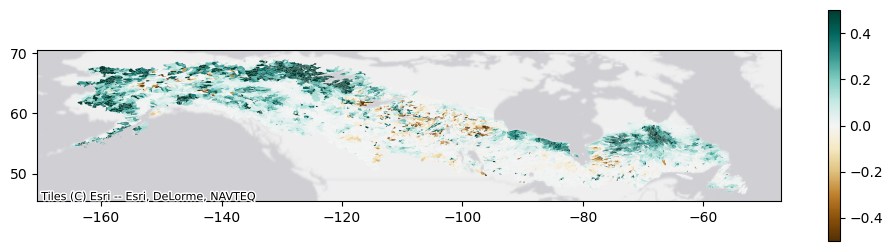

In [24]:
ax = hydrobasins.to_crs(4326).plot(column='val_terrapulse_tcc_slope_median', cmap='BrBG', legend=True, vmin=-0.5, vmax=0.5, figsize=(12,3))
ax = ctx.add_basemap(ax=ax, crs=4326, source = ctx.providers.Esri.WorldGrayCanvas)

In [ ]:
LIST_GPKG_DONE = hydrobasins.HYBAS_ID.to_list()

In [15]:
# Get missing
LIST_HYBAS_ID_COG_FINISHED= [int(os.path.basename(f).split('_')[2]) for f in glob.glob(OUTDIR + '/*cog.tif' )]
print(f'{len(LIST_HYBAS_ID_COG_FINISHED)} basin clip cogs that have been processed.')

LIST_HYBAS_ID_COG_MISSING = [id for id in HYBAS_ID_LIST if id not in LIST_HYBAS_ID_COG_FINISHED]
print(f'{len(LIST_HYBAS_ID_COG_MISSING)} basin clip cogs still missing')

LIST_HYBAS_ID_GPKG_FINISHED= [int(os.path.basename(f).split('_')[2]) for f in glob.glob(ZONAL_DIR + '/*cog_zonalstats.gpkg' )] + LIST_GPKG_DONE
                            
print(f'{len(LIST_HYBAS_ID_GPKG_FINISHED)} zonal GPKGs that have been processed.')

LIST_HYBAS_ID_GPKG_MISSING = [id for id in LIST_HYBAS_ID_COG_FINISHED if id not in LIST_HYBAS_ID_GPKG_FINISHED]
print(f'{len(LIST_HYBAS_ID_GPKG_MISSING)} zonal GPKGs available to process ')

15366 basin clip cogs that have been processed.
1686 basin clip cogs still missing
26638 zonal GPKGs that have been processed.
21 zonal GPKGs available to process 


## Process the landscape (hydrobasin) trends in tree canopy cover
Accessible from:  
s3://terrapulse-pub-data/boreal-forest-data

Using boreal calibrated tree canopy cover from:  
Feng et al. 2022 | https://doi.org/10.3334/ORNLDAAC/2012


### Step [1]: build stack of tcc_slope and tcc_pvalue for basins

In [ ]:
#%%capture captured_output_text
with Pool(processes=25) as pool:
    pool.map(partial(run_build_stack), list(reversed(LIST_HYBAS_ID_COG_MISSING)) )

In [22]:
LIST_HYBAS_ID_GPKG_MISSING

[7080106402,
 7080133791,
 7080137251,
 7080149580,
 7080159602,
 7080161581,
 7080169902,
 7080223022,
 7080245462,
 7080256461,
 8080019662,
 8080091580,
 8080118180,
 8080122730,
 8080155920,
 8080191441,
 8080199310,
 8080245802,
 8080258171]

### Step [2]: get zonal stats of stack for basin

In [12]:
# Test
if True:
    TEST_LIST_HYBAS = [7080224740]
    [extract_zonal_gdf_poly(HYBAS_ID, bandnames = [d['RASTER_NAME'] for d in BUILD_STACK_DICT_LIST], GDF_fn = INDEX_FN ) for HYBAS_ID in TEST_LIST_HYBAS]

	Extracting raster values from:  /projects/my-public-bucket/databank/boreal_height_cmip6/output/build_stack_basin_clips/build_stack_7080224740_cog.tif


In [ ]:
#%%capture captured_output_text
if True:
    [extract_zonal_gdf_poly(HYBAS_ID, bandnames = [d['RASTER_NAME'] for d in BUILD_STACK_DICT_LIST], GDF_fn = INDEX_FN ) for HYBAS_ID in LIST_HYBAS_ID_GPKG_MISSING]
else:
    with Pool(processes=25) as pool:
        returned_stuff = pool.map(partial(extract_zonal_gdf_poly, 
                                          bandnames = [d['RASTER_NAME'] for d in BUILD_STACK_DICT_LIST], 
                                          GDF_fn = INDEX_FN ), 
                                  list(reversed(LIST_HYBAS_ID_GPKG_MISSING))
                                 )

## Check landscape (hydrobasin) summaries of trend in tree canopy cover

In [32]:
hydrobasins = gpd.read_file('/projects/my-public-bucket/databank/boreal_height_cmip6/output/hydrobasins_L08_patterns_tte_boreal_tundra_tcc_trends.gpkg')
float_cols = hydrobasins.filter(like='val_', axis=1).columns
hydrobasins[float_cols] = hydrobasins[float_cols].apply(pd.to_numeric)

In [33]:
hydrobasins.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 15317 entries, 0 to 15316
Data columns (total 24 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   level_0                                  15317 non-null  int64   
 1   index                                    15317 non-null  int64   
 2   HYBAS_ID                                 15317 non-null  int64   
 3   pattern_class                            15317 non-null  object  
 4   val_terrapulse_tcc_slope_max             12734 non-null  float64 
 5   val_terrapulse_tcc_slope_min             12734 non-null  float64 
 6   val_terrapulse_tcc_slope_median          12734 non-null  float64 
 7   val_terrapulse_tcc_slope_mean            12734 non-null  float64 
 8   val_terrapulse_tcc_slope_percentile_02   12734 non-null  float64 
 9   val_terrapulse_tcc_slope_percentile_25   12734 non-null  float64 
 10  val_terrapulse_tcc_slope_p

In [34]:
hydrobasins.columns

Index(['level_0', 'index', 'HYBAS_ID', 'pattern_class',
       'val_terrapulse_tcc_slope_max', 'val_terrapulse_tcc_slope_min',
       'val_terrapulse_tcc_slope_median', 'val_terrapulse_tcc_slope_mean',
       'val_terrapulse_tcc_slope_percentile_02',
       'val_terrapulse_tcc_slope_percentile_25',
       'val_terrapulse_tcc_slope_percentile_75',
       'val_terrapulse_tcc_slope_percentile_98',
       'val_terrapulse_tcc_slope_count', 'val_terrapulse_tcc_pvalue_max',
       'val_terrapulse_tcc_pvalue_min', 'val_terrapulse_tcc_pvalue_median',
       'val_terrapulse_tcc_pvalue_mean',
       'val_terrapulse_tcc_pvalue_percentile_02',
       'val_terrapulse_tcc_pvalue_percentile_25',
       'val_terrapulse_tcc_pvalue_percentile_75',
       'val_terrapulse_tcc_pvalue_percentile_98',
       'val_terrapulse_tcc_pvalue_count', 'area_sqkm', 'geometry'],
      dtype='object')

In [35]:
import plotnine
from plotnine import *

In [ ]:
import numpy as np

In [136]:
p_val_crit = 0.1

In [137]:
# Calc proportion of basins with pvals below critical level
condition_1 = hydrobasins['val_terrapulse_tcc_pvalue_median'].lt(p_val_crit)
hydrobasins['significance'] = np.where(condition_1, f'p<{p_val_crit}',f'p>={p_val_crit}')

hydrobasins_smry = hydrobasins.groupby(['significance', 'pattern_class']).aggregate(count_class=('pattern_class', 'count')).reset_index()
hydrobasins_smry

,significance,pattern_class,count_class
0,p<0.1,Boreal Forest (taiga),4406
1,p<0.1,Non-forest (tundra),5
2,p<0.1,TTE (abrupt edge),39
3,p<0.1,TTE (abrupt),191
4,p<0.1,TTE (diffuse),4056
5,p<0.1,TTE (uniform),254
6,p>=0.1,Boreal Forest (taiga),3537
7,p>=0.1,Non-forest (tundra),283
8,p>=0.1,TTE (abrupt edge),876
9,p>=0.1,TTE (abrupt),571


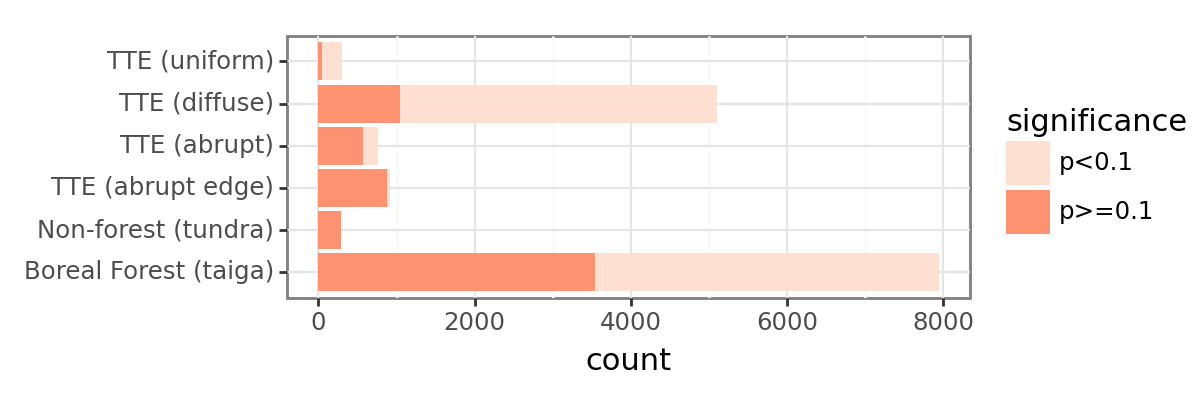

<Figure Size: (600 x 200)>

In [138]:
(
    ggplot(hydrobasins_smry)
    + geom_bar(aes(y='count_class', x='pattern_class', fill='significance'), stat='identity')
    + scale_fill_brewer(palette='Reds')
    + theme_bw()
    + theme(figure_size=(6,2))
    + labs(x='', y='count')
    + coord_flip()
)

/opt/conda/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin_2d : Removed 2583 rows containing non-finite values.


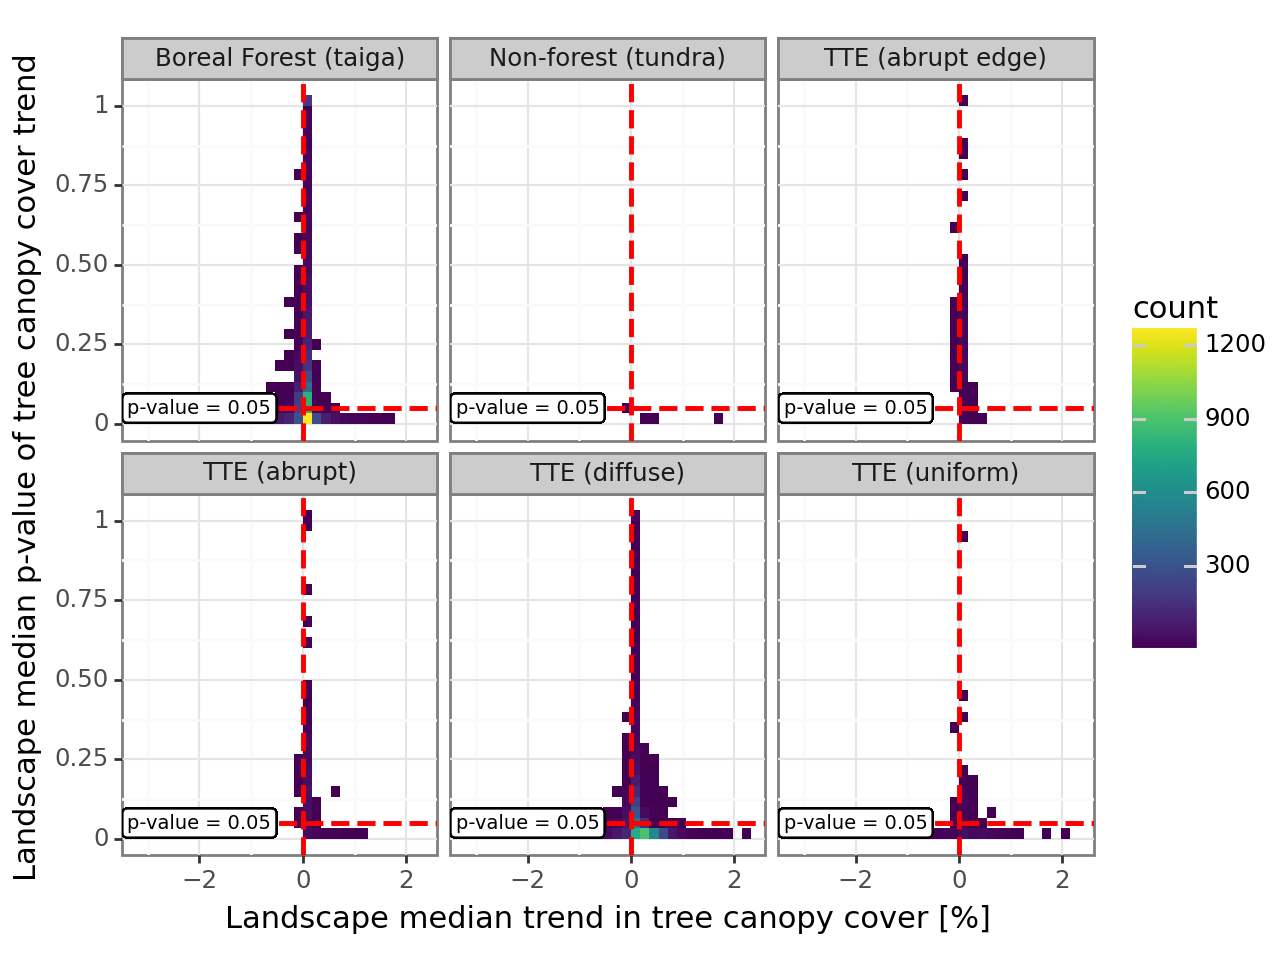

<Figure Size: (640 x 480)>

In [93]:
(
  ggplot(data = hydrobasins) 
    + geom_bin2d(mapping=aes(x='val_terrapulse_tcc_slope_median', y='val_terrapulse_tcc_pvalue_median'))
    + geom_vline(xintercept=0, linetype='dashed', color='red', size=1.0)
    + geom_hline(yintercept=p_val_crit, linetype='dashed', color='red', size=1.0)
    + geom_label(x=-2, y=p_val_crit, label=f'p-value = {p_val_crit}', size=7)
    #+ geom_hline(yintercept=0.01, linetype='dashed', color='red', size=1.5)

    #+ geom_point(mapping=aes(x='val_terrapulse_tcc_slope_median', y='val_terrapulse_tcc_pvalue_median'), alpha=0.1)
    + theme_bw()
    + labs(x = 'Landscape median trend in tree canopy cover [%]',
           y = 'Landscape median p-value of tree canopy cover trend'
          )
    + facet_wrap('~pattern_class')
)